<a href="https://colab.research.google.com/github/eldhosejoseph/thesis/blob/main/ce901_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CE 901 -DISSERTATION**



Name: Eldhose Joseph

Supervisor: Prof. Ian Daly

University: University of Essex

Course: MSc. AI and its Applications

Topic:

#============================================================================

**ABSTRACT**




This is the analysis interactive code file for the master's thesis.

# DATASET

**Dataset**

An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Paper: https://www.nature.com/articles/s41597-024-03234-y :An EEG Dataset of Neural Signatures in a Competitive Two-Player Game Encouraging Deceptive Behavior

Pre-print: https://assets-eu.researchsquare.com/files/rs-2521275/v1_covered.pdf?c=1676412896

Supplementary Files: https://assets-eu.researchsquare.com/files/rs-2521275/v1/ee537dc92ed9e0bcb9e4ca87.pdf

Dataset: https://figshare.com/articles/dataset/An_EEG_Dataset_of_Neural_Signatures_in_a_Competitive_Two-Player_Game_Encouraging_Deceptive_Behavior/24760827/3

git: https://github.com/yiyuchen-lab/DeceptionGame


# Libraries and Packages

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.8 MB/s eta 0:00:00


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.3 MB/s eta 0:00:00


In [3]:
import mne
import os
import re
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix
from mne.decoding import CSP
from scipy.fft import fft
from scipy.linalg import eigh
from scipy.stats import ttest_ind
from itertools import combinations
import ast
import pywt
from sklearn.feature_selection import f_classif
from scipy.signal import welch

In [4]:
import numpy as np
import pandas as pd
import os
import re
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from scipy.stats import skew, kurtosis
from scipy.fft import fft2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from itertools import combinations


# Data Set Import

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def eegfiles(n):

    def get_filtered_files(folder_path):
        # Regular expression pattern to match the required file format
        pattern = re.compile(r'Player_(sub\d+)_Observer_(sub\d+)\.mat')

        # Dictionary to store the filtered files
        filtered_files = {}

        # Check if the folder exists
        if not os.path.isdir(folder_path):
            print(f"The folder '{folder_path}' does not exist.")
            return filtered_files

        # Iterate over files in the specified folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.mat'):
                match = pattern.match(filename)
                if match:
                    player_id = match.group(1)
                    p_key = f"p{int(player_id[3:])}"  # Convert subXX to pX
                    if p_key not in filtered_files:
                        filtered_files[p_key] = []
                    # Store the file path in the dictionary
                    filtered_files[p_key].append(os.path.join(folder_path, filename))

        return filtered_files

    def get_key_list(filtered_files):
        # Return the list of keys
        return list(filtered_files.keys())

    def get_specific_files(filtered_files, key):
        # Return the list of files for the specified key
        return filtered_files.get(key, [])

    # Specify the folder containing the .txt files
    folder_path = '//content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking'

    # Get the filtered files
    filtered_files = get_filtered_files(folder_path)

    # Get the list of keys
    keys = get_key_list(filtered_files)

    # Print the list of keys
    #print("List of keys:", keys)

    # Get specific files for a key, e.g., p1
    keys = [f'p{i}' for i in range(1, 25) if i != 2]
    key_to_retrieve = keys[n]
    specific_files = get_specific_files(filtered_files, key_to_retrieve)

    # Print the files for the specified key
    #print(f"\nFiles for {key_to_retrieve}:")
    for file in specific_files:
        #print(f"  {file}")
        return  file

In [7]:
# Define options
opt = {
    'preprocessedData_path': '/content/drive/MyDrive/thesisdata/eegdataset/24760827eeg/Preprocessed/Preprocessed/DecisionMaking',
    'epoch_type': ['DecisionMaking'],
    'session_role': ['player','observer'],
    'eegmarker_label': {
        'showCard': ['sponL', 'sponT', 'instL', 'instT']
    }
}

# Load data
data_path = os.path.join(opt['preprocessedData_path'], opt['epoch_type'][0])

files=[]
for n in range(23):
  files.append(eegfiles(n))

filenames = [f for f in files if f.endswith('.mat')]
epos = []
for file in filenames:
    mat = sio.loadmat(os.path.join(data_path, file))
    epos.append(mat[opt['session_role'][0]])

In [8]:
def player_df(player):
    # Data extraction based on the provided indices and modes
    # Extract EEG data for each trial
    eeg_data = epos[player][0][0][1]

    # Extract channel names
    ch_names = epos[player][0][0][2][0]

    # Extract samples (trial categories)
    samples = epos[player][0][0][3]

    # Extract cards (round and trial data)
    cards = epos[player][0][0][4][0]

    # Extract timestamps
    timestamps = epos[player][0][0][5][0]

    # Create an empty list to store the rows of the dataframe
    data_rows = []

    # Number of rounds and trials per round
    num_rounds = 11
    trials_per_round = 44

    # Map sample indices to categories
    sample_to_category = {0: 'sponL', 1: 'sponT', 2: 'instT', 3: 'instL'}  #changed here

    # Loop through the rounds and trials to create rows for the dataframe
    for r in range(num_rounds):
        for t in range(trials_per_round):
            # Calculate the overall trial index
            trial_index = r * trials_per_round + t

            # Check if trial_index is within bounds
            if trial_index >= len(samples[0]):
                continue

            # Determine the category for the current trial
            category = None
            for cat_index, trials in enumerate(samples):
                if trials[trial_index] == 1:
                    category = sample_to_category[cat_index]
                    break

            # Create a row for the dataframe
            row = [r+1, t+1, category]

            # Append EEG data for each channel to the row as a list of values
            for ch in range(30):
                channel_data = [eeg_data[i][ch][trial_index] for i in range(350)]
                row.append(channel_data)

            # Append the row to the list of data rows
            data_rows.append(row)

    # Create column names
    column_names = ['round', 'trial', 'category'] + [f'channel_{i}' for i in range(1,31)]

    # Create the dataframe
    df = pd.DataFrame(data_rows, columns=column_names)

    return df

# ERP ANALYSIS

In [10]:
ch_names=epos[0][0][0][2][0]

In [79]:
ch_names.tolist()

[array(['F7'], dtype='<U2'),
 array(['F3'], dtype='<U2'),
 array(['Fz'], dtype='<U2'),
 array(['F4'], dtype='<U2'),
 array(['F8'], dtype='<U2'),
 array(['FC5'], dtype='<U3'),
 array(['FC1'], dtype='<U3'),
 array(['FC2'], dtype='<U3'),
 array(['FC6'], dtype='<U3'),
 array(['T7'], dtype='<U2'),
 array(['C3'], dtype='<U2'),
 array(['Cz'], dtype='<U2'),
 array(['C4'], dtype='<U2'),
 array(['T8'], dtype='<U2'),
 array(['CP5'], dtype='<U3'),
 array(['CP1'], dtype='<U3'),
 array(['CP2'], dtype='<U3'),
 array(['CP6'], dtype='<U3'),
 array(['P7'], dtype='<U2'),
 array(['P3'], dtype='<U2'),
 array(['Pz'], dtype='<U2'),
 array(['P4'], dtype='<U2'),
 array(['P8'], dtype='<U2'),
 array(['PO3'], dtype='<U3'),
 array(['PO4'], dtype='<U3'),
 array(['O1'], dtype='<U2'),
 array(['O2'], dtype='<U2'),
 array(['F9'], dtype='<U2'),
 array(['F10'], dtype='<U3'),
 array(['Fp2'], dtype='<U3')]

In [11]:
def grand_average(channel_num):
  if channel_num in range(1,31):
      all_players_data = []

      # Iterate through all players and gather their data
      for p in range(len(epos)):
          df = player_df(p)
          all_players_data.append(df)

      # Combine all players' data into one DataFrame
      combined_df = pd.concat(all_players_data, ignore_index=True)

      # Initialize a dictionary to hold the grand average for each category
      grand_averages = {'sponL': [], 'sponT': [], 'instL': [], 'instT': []}

      # Calculate the grand average for each category
      for category in grand_averages.keys():
          category_data = combined_df[combined_df['category'] == category]

          # Collect all EEG lists for the specified channel across all trials for the current category
          all_eeg_lists = np.array(category_data[f'channel_{channel_num}'].tolist())

          # Calculate the grand average by taking the mean across the first dimension (trials)
          grand_averages[category] = np.mean(all_eeg_lists, axis=0)
  return grand_averages

def plot_erp(channel_num):
    if channel_num in range(1,31):
      grand_averages=grand_average(channel_num)

      # Extract timestamps
      timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

      # Define the range for x-axis in milliseconds
      x_range = (-100, 700)
      timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

      # Filter the timestamps and grand averages to include only the desired range
      valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

      # Plot the grand averages
      plt.figure(figsize=(10, 6))
      color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
      for category, data in grand_averages.items():
          #plt.plot(data, label=category)
          plt.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

      plt.title(f'Grand Average ERP for Channel {channel_num}[{ch_names[channel_num-1][0]}]')
      plt.xlabel('Time Points')
      plt.ylabel('EEG Amplitude')
      plt.legend()
      plt.grid(True)
      plt.show()

    else:
      print('Channel Num range: [1,30]')

In [12]:
#grand_average(0)

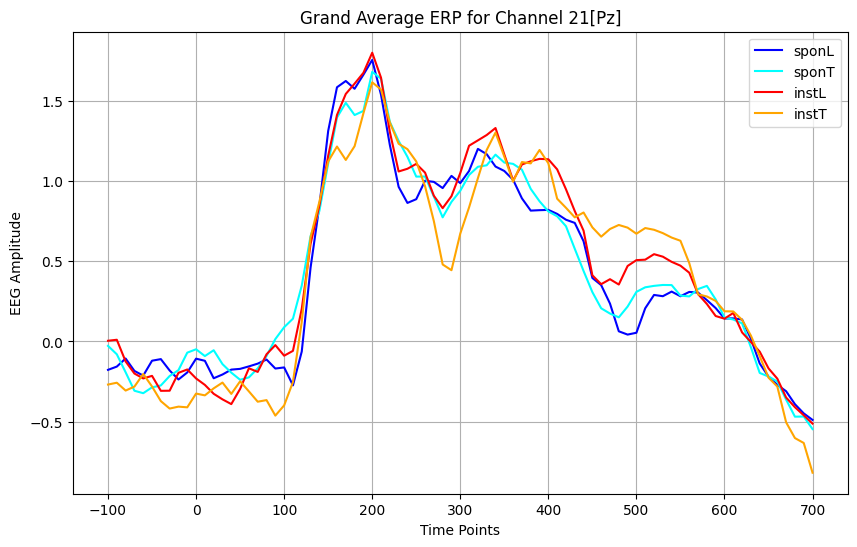

In [13]:
plot_erp(21)

In [14]:
def plot_all_channels():
    # Extract timestamps
    timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

    # Define the range for x-axis in milliseconds
    x_range = (-100, 700)
    timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

    # Filter the timestamps to include only the desired range
    valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

    # Create subplots
    fig, axs = plt.subplots(6, 5, figsize=(20, 20))
    fig.suptitle('Grand Average ERP for All Channels')

    for channel_num in range(1, 31):
        grand_averages = grand_average(channel_num)

        row = (channel_num - 1) // 5
        col = (channel_num - 1) % 5
        ax = axs[row, col]

        color_cat={'sponL': 'blue', 'sponT': 'cyan' , 'instT': 'orange' , 'instL': 'red' }
        for category, data in grand_averages.items():
            ax.plot(timestamps_ms[valid_indices], np.array(data)[valid_indices], label=category, color=color_cat[category])

        ax.set_title(f'Channel {channel_num} [{ch_names[channel_num-1][0]}]')
        ax.set_xlabel('Time Points (ms)')
        ax.set_ylabel('EEG Amplitude')
        ax.legend()
        ax.grid(True)
        if channel_num == 1:
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#plot_all_channels()

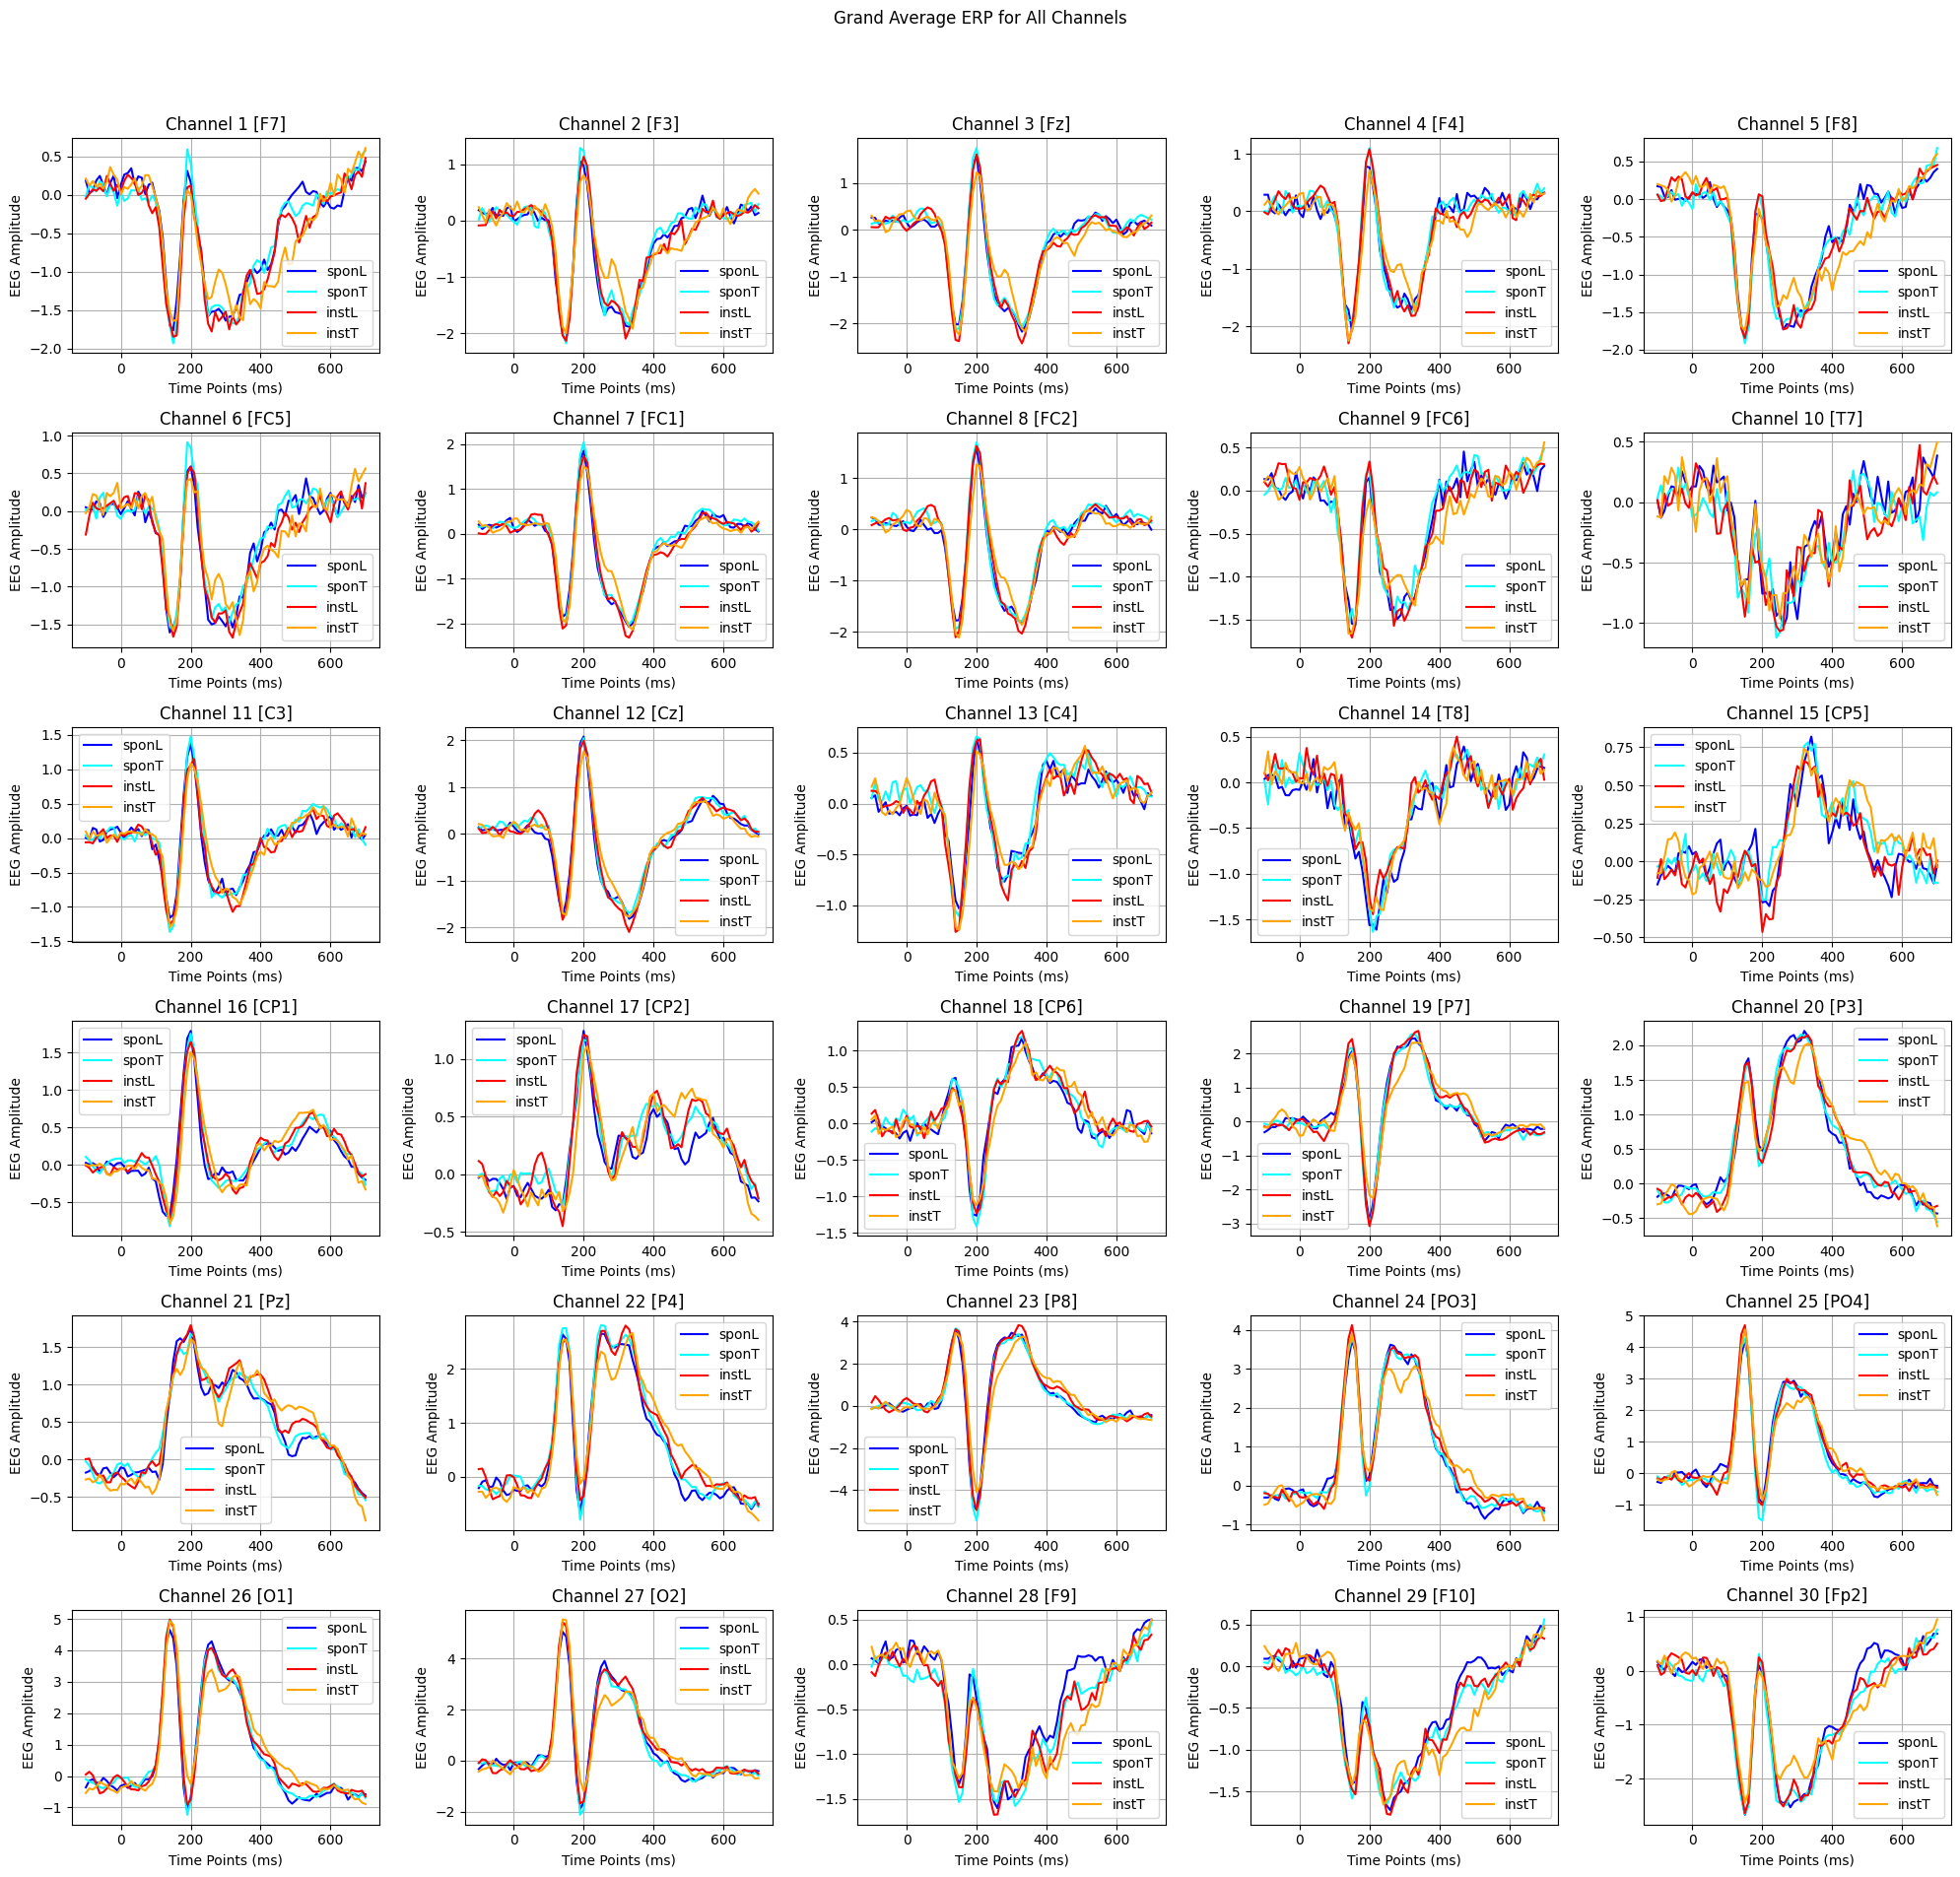

# DATASET TRANSFORMATION

In [15]:
def dataset(channel_num):
  eeg=[]
  category=[]
  for player in range(23):
    df=player_df(player)
    category.append(df[df.columns[2]].values)
    eeg.append(df[df.columns[channel_num+2]].values)

  data={'x':eeg, 'y':category}
  return pd.DataFrame(data)

# Function to expand the DataFrame
def expand_dataframe(df):
    expanded_rows = []
    for player in range(23):  # Iterate over each player
      if player==19:trials=483
      elif player==21:trials=482
      else:trials=484
      for trial in range(trials):  # Iterate over each trial (484 trials)
            x_values = df.iloc[player, 0][trial]  # Extract the list of 350 values
            y_value = df.iloc[player, 1][trial]   # Extract the corresponding y value
            expanded_rows.append({'x': x_values, 'y': y_value})
    return pd.DataFrame(expanded_rows)

In [16]:
channel=21 #channel: 1 to 30
ch21=expand_dataframe(dataset(channel))
ch21

,x,y
0,"[1.322716236114502, 2.994771718978882, 6.41149...",instL
1,"[-3.844251871109009, -3.7300541400909424, -2.4...",instT
2,"[-4.691122531890869, -1.633573293685913, -0.56...",sponL
3,"[3.3362035751342773, 5.152755260467529, 4.7315...",sponT
4,"[0.20543311536312103, -0.11058960109949112, -2...",sponT
...,...,...
11124,"[2.688664436340332, 5.636557102203369, 3.92807...",instL
11125,"[-0.6962383389472961, 1.46507728099823, -2.223...",instL
11126,"[-3.8817899227142334, 0.4896158277988434, 0.76...",sponT
11127,"[-0.06153459846973419, -3.9250741004943848, -1...",sponT


In [17]:
def p300_df(df):
    def time_window(l,u):
          # Extract timestamps
          timestamps = epos[0][0][0][5][0]  # Assuming timestamps are the same for all players

          # Define the range for x-axis in milliseconds
          x_range = (l, u)
          timestamps_ms = np.array(timestamps)  # Convert timestamps to milliseconds

          # Filter the timestamps to include only the desired range
          valid_indices = np.where((timestamps_ms >= x_range[0]) & (timestamps_ms <= x_range[1]))[0]

          return valid_indices

    def eeg_window(eeg, timewindow):
        eeg=[eeg[i] for i in time_window(timewindow[0],timewindow[1])]
        return eeg


    def mean(list):
      mean=sum(list)/len(list)
      return mean

    def erp_time_window(eeg_df, time_window):
      #eeg_df=dataset(channel_num)
      x=eeg_df['x']
      y=eeg_df['y']
      x_new=[]
      for i in range(len(x)):
        x_new.append((eeg_window(x[i],time_window)))

      eeg_df_n=pd.DataFrame({'x':x_new, 'y':y})
      return eeg_df_n

    return erp_time_window(df, [250, 500])

In [18]:
ch21_p300=p300_df(expand_dataframe(dataset(21)))
ch21_p300

,x,y
0,"[-0.3757180869579315, 1.5885050296783447, 0.53...",instL
1,"[-2.4870445728302, 4.088906764984131, 3.310979...",instT
2,"[-4.7962517738342285, -1.4890989065170288, -1....",sponL
3,"[-6.236530303955078, -6.72092342376709, -5.495...",sponT
4,"[-2.0842483043670654, -1.3741694688796997, 1.1...",sponT
...,...,...
11124,"[-0.2080729752779007, -1.6513162851333618, -1....",instL
11125,"[-2.7477426528930664, -0.6444938778877258, -1....",instL
11126,"[-3.3445396423339844, 0.36243292689323425, -0....",sponT
11127,"[-0.43944233655929565, -2.3280997276306152, -5...",sponT


# STATISTICAL TEST

In [19]:
def plot_channel_boxplot(df, channel_number):
    """
    Plot a box plot of EEG values for a specific channel, categorized by label.

    Parameters:
    - df: DataFrame with columns 'x' (list of EEG values) and 'y' (labels).
    - channel_number: Integer, the channel number to analyze (1-based index).

    Returns:
    - None: Displays a box plot with different colors for each label.
    """
    if channel_number < 1 or channel_number > 30:
        raise ValueError("Channel number must be between 1 and 30.")
    else:
      # Ensure that 'x' is a list of lists
      if not isinstance(df['x'].iloc[0], list):
          raise ValueError("'x' column must contain lists of EEG values.")

      # Convert 1-based index to 0-based index
      channel_index = channel_number - 1

      # Check if channel_index is within the range of EEG data
      if any(len(x) <= channel_index for x in df['x']):
          raise ValueError(f"Channel number {channel_number} is out of range for some EEG data.")

      # Extract EEG values for the specified channel
      df['channel_value'] = df['x'].apply(lambda x: x[channel_index])

      # Prepare data for plotting
      grouped_data = df.groupby('y')['channel_value'].apply(list)

      # Create a box plot
      plt.figure(figsize=(10, 6))

      # Plot boxplot
      plt.boxplot(grouped_data, labels=grouped_data.index, patch_artist=True)

      # Customize plot
      plt.xlabel('Labels')
      plt.ylabel(f'EEG Values for Channel {channel_number}')
      plt.title(f'Box Plot of EEG Values for Channel {channel_number} by Label')
      plt.grid(True)
      plt.show()



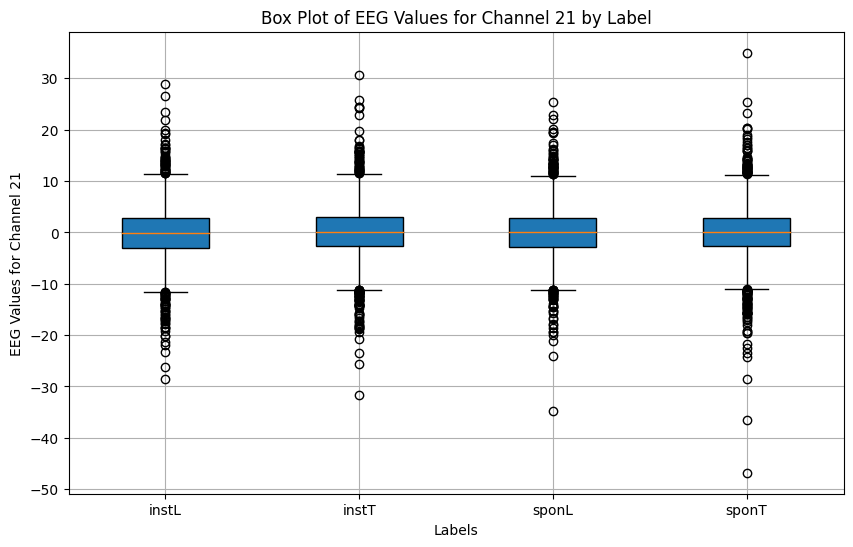

In [20]:
df=expand_dataframe(dataset(channel))
channel_number=21
plot_channel_boxplot(df, channel_number)

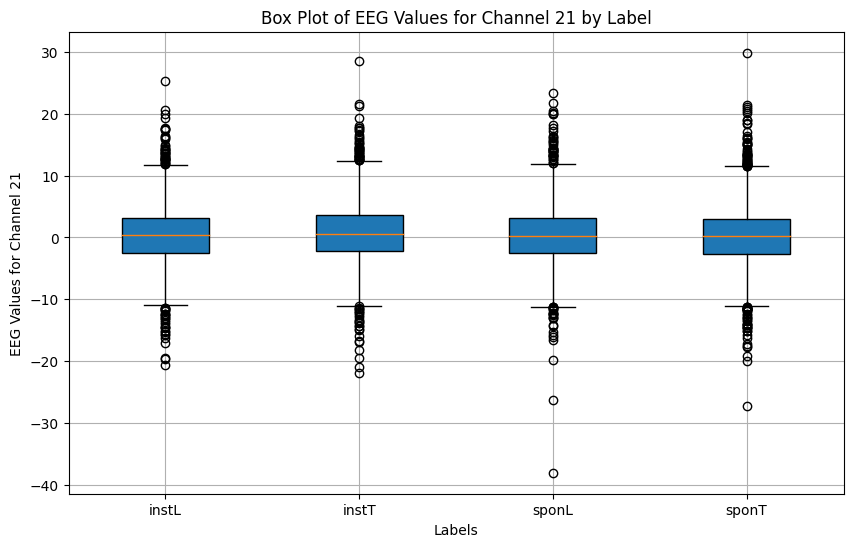

In [21]:
df=p300_df(expand_dataframe(dataset(channel)))
channel_number=21
plot_channel_boxplot(df, channel_number)

In [22]:
def plot_distribution_of_means(df):
    # Calculate the mean of each row in the 'x' column
    df['x_mean'] = df['x'].apply(np.mean)

    # Plot the distribution of means for each category in 'y'
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='x_mean', hue='y', kde=True, bins=30)
    plt.title('Distribution of Means for Each Category')
    plt.xlabel('Mean of x')
    plt.ylabel('Density')
    plt.show()

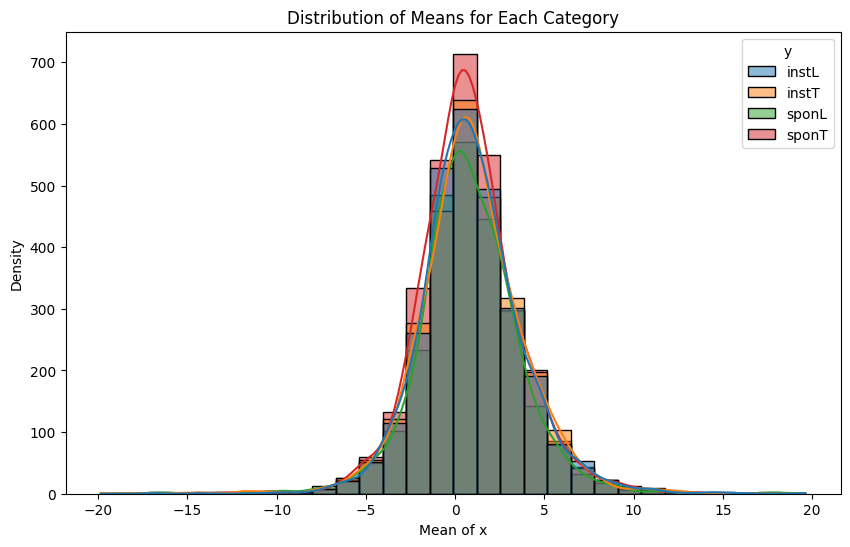

In [23]:
plot_distribution_of_means(ch21_p300)

In [24]:
from scipy.stats import shapiro

def check_normality(df):
    df['x_mean'] = df['x'].apply(np.mean)
    results = {}

    for category in df['y'].unique():
        data = df[df['y'] == category]['x_mean']
        stat, p_value = shapiro(data)
        results[category] = {'statistic': stat, 'p_value': p_value}

    # Output normality test results
    for category, result in results.items():
        print(f"Category: {category}, Shapiro-Wilk Test Statistic: {result['statistic']:.4f}, p-value: {result['p_value']:.4f}")
        if result['p_value'] < 0.05:
            print(f"Data in category {category} seems to be normally distributed (reject H0).")
        else:
            print(f"Data in category {category} does not seem to be normally distributed (fail to reject H0).")

In [25]:
check_normality(ch21_p300)

Category: instL, Shapiro-Wilk Test Statistic: 0.9709, p-value: 0.0000
Data in category instL seems to be normally distributed (reject H0).
Category: instT, Shapiro-Wilk Test Statistic: 0.9672, p-value: 0.0000
Data in category instT seems to be normally distributed (reject H0).
Category: sponL, Shapiro-Wilk Test Statistic: 0.9629, p-value: 0.0000
Data in category sponL seems to be normally distributed (reject H0).
Category: sponT, Shapiro-Wilk Test Statistic: 0.9743, p-value: 0.0000
Data in category sponT seems to be normally distributed (reject H0).


======= t -test for 4 classes===============

In [26]:
def perform_t_tests(channel_nums):
    results_columns = ['channel_num']
    results = pd.DataFrame(columns=results_columns)

    for channel in channel_nums:
        df = p300_df(expand_dataframe(dataset(channel)))

        # Debugging print statements
        #print(f"Processing channel: {channel}")
        #print(f"DataFrame structure:\n{df.head()}")

        if 'y' not in df.columns or 'x' not in df.columns:
            raise ValueError(f"The DataFrame for channel {channel} is missing 'x' or 'y' columns.")

        categories = df['y'].unique()
        row = {'channel_num': channel}

        if len(results_columns) == 1:
            results_columns += [f'{pair[0]} vs {pair[1]}' for pair in combinations(categories, 2)]
            results = pd.DataFrame(columns=results_columns)

        for pair in combinations(categories, 2):
            group1_means = df[df['y'] == pair[0]]['x'].apply(np.mean)
            group2_means = df[df['y'] == pair[1]]['x'].apply(np.mean)

            # Debugging print statements
            #print(f"Comparing: {pair[0]} vs {pair[1]}")
            #print(f"Group 1 means:\n{group1_means}")
            #print(f"Group 2 means:\n{group2_means}")

            t_stat, p_value = ttest_ind(group1_means, group2_means)
            row[f'{pair[0]} vs {pair[1]}'] = 1 if p_value < 0.05 else 0
        print(f'channel {channel}done')

        # Convert the row to a DataFrame and concatenate it with the results
        row_df = pd.DataFrame([row])
        results = pd.concat([results, row_df], ignore_index=True)


    return results

In [27]:
channel_nums = [i for i in range(1,31)]
result_t_test= perform_t_tests(channel_nums)

channel 1done
channel 2done
channel 3done
channel 4done
channel 5done
channel 6done
channel 7done
channel 8done
channel 9done
channel 10done
channel 11done
channel 12done
channel 13done
channel 14done
channel 15done
channel 16done
channel 17done
channel 18done
channel 19done
channel 20done
channel 21done
channel 22done
channel 23done
channel 24done
channel 25done
channel 26done
channel 27done
channel 28done
channel 29done
channel 30done


In [28]:
print('1 if significant difference in mean, else 0')
result_t_test

1 if significant difference in mean, else 0


,channel_num,instL vs instT,instL vs sponL,instL vs sponT,instT vs sponL,instT vs sponT,sponL vs sponT
0,1,0,0,0,1,1,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,0,0,0,0
5,6,0,0,1,0,1,0
6,7,1,0,1,0,0,0
7,8,0,0,0,0,0,0
8,9,0,0,1,0,1,0
9,10,0,0,0,0,0,0


# Pipeline

In [29]:
def create_dflist():
    print("Creating list of dataframes")
    df=[]
    for channel in selected_channels:
      d=p300_df(expand_dataframe(dataset(channel)))
      df.append(d)
      print(f"channel {channel} done")

    print("List of dataframes done")
    return df

def create_2dflist():
    innocent = ['instT', 'sponT']  # Add the class labels you consider "innocent"
    guilty = ['instL']    # Add the class labels you consider "guilty"

    print("Creating list of dataframes")
    df=[]
    for channel in selected_channels:
      d=p300_df(expand_dataframe(dataset(channel)))
      #df.append(d)

      # Ensure the column 'y' exists
      if 'y' not in d.columns:
          raise KeyError("The DataFrame does not have a 'y' column. Please check the column names.")

      # Define the mapping function
      def map_class(y):
          if y in innocent:
             return 'innocent'
          elif y in guilty:
             return 'guilty'
          else:
             return 'unknown'  # Handle cases where y is not in either list

      # Apply the mapping to the 'y' column
      d['y'] = d['y'].apply(map_class)
      df.append(d)

      print(f"channel {channel} done")

    print("List of dataframes done")
    return df


In [30]:
# Bispectrum calculation functions
# Convert string to array (as provided)
def convert_string_to_array(string):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", string)
    return np.array(numbers, dtype=np.float64)

def compute_third_order_cumulant(signal_segment):
    N = len(signal_segment)
    C3 = np.zeros((N, N), dtype=np.complex128)

    for n1 in range(N):
        for n2 in range(N):
            C3[n1, n2] = np.mean(signal_segment * np.roll(signal_segment, n1) * np.roll(signal_segment, n2))

    return C3

def compute_bispectrum(C3):
    return fft2(C3)

def extract_statistical_features(bispectrum):
    T1, T2 = bispectrum.shape
    bispectrum_flat = np.abs(bispectrum).flatten()

    mean_bispectrum = np.mean(bispectrum_flat)
    variance_bispectrum = np.var(bispectrum_flat)
    skewness_bispectrum = skew(bispectrum_flat)
    kurtosis_bispectrum = kurtosis(bispectrum_flat)

    return mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum

def bispectrum_feature_extraction(df, segment_length=26, overlap=0, fs=1):
    data = []

    segment_samples = segment_length
    overlap_samples = overlap

    #print("Segment samples:", segment_samples)
    #print("Overlap samples:", overlap_samples)

    for index, row in df.iterrows():
        eeg_signal = np.array(row['x'])  # Convert the list of EEG values to a numpy array
        label = row['y']  # Label is a string

        #print(f"\nProcessing row {index} with label: {label}")
        #print("EEG signal length:", len(eeg_signal))

        if len(eeg_signal) < segment_samples:
            print(f"EEG signal length ({len(eeg_signal)}) is shorter than the segment length ({segment_samples}).")
            continue

        # Use full signal as segment if shorter than segment length
        start = 0
        while start + segment_samples <= len(eeg_signal):
            segment = eeg_signal[start:start + segment_samples]

            #print(f"Segment start index: {start}, end index: {start + segment_samples}")
            #print("Segment length:", len(segment))

            # Compute the third-order cumulant and bispectrum
            C3 = compute_third_order_cumulant(segment)
            bispectrum = compute_bispectrum(C3)

            #print("C3 shape:", C3.shape)
            #print("Bispectrum shape:", bispectrum.shape)

            # Extract statistical features
            mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum = extract_statistical_features(bispectrum)

            #print("Mean of bispectrum:", mean_bispectrum)
            #print("Variance of bispectrum:", variance_bispectrum)
            #print("Skewness of bispectrum:", skewness_bispectrum)
            #print("Kurtosis of bispectrum:", kurtosis_bispectrum)

            # Append features and label to the data list
            data.append([mean_bispectrum, variance_bispectrum, skewness_bispectrum, kurtosis_bispectrum, label])

            start += segment_samples - overlap_samples

        #print(f"Total segments for row {index}: {len(data)}")

    # Create a DataFrame from the extracted features
    features_df = pd.DataFrame(data, columns=['mean', 'variance', 'skewness', 'kurtosis', 'y'])

    #print("\nFeatures DataFrame:")
    #print(features_df.head())
    #print("Total segments processed:", len(features_df))

    return features_df



def extract_csp_features(dataframes, top_n=2, bottom_n=2):
    variances = []

    for df in dataframes:
        feature_columns = [col for col in df.columns if col != 'y']
        X = df[feature_columns].values
        y = df['y'].values

        # Convert labels to integers
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Reshape for CSP: (n_samples, n_channels, n_time_points)
        # Here, n_channels is the number of statistical features
        # and n_time_points is 1 (since we don't have a time series)
        n_samples = X.shape[0]
        n_channels = X.shape[1]
        n_time_points = 1

        X_reshaped = X.reshape((n_samples, n_channels, n_time_points))

        # Apply CSP
        csp = CSP(n_components=min(n_channels, n_samples), log=True)
        csp.fit(X_reshaped, y_encoded)
        transformed_features = csp.transform(X_reshaped)
        component_variance = np.var(transformed_features, axis=0).mean()

        variances.append(component_variance)

    variances = np.array(variances)

    # Select top and bottom channels based on variance
    ranked_indices = np.argsort(variances)
    selected_indices = np.concatenate([ranked_indices[:bottom_n], ranked_indices[-top_n:]])

    all_features = []
    all_labels = []

    for idx in selected_indices:
        df = dataframes[idx]
        feature_columns = [col for col in df.columns if col != 'y']
        X = df[feature_columns].values
        y = df['y'].values

        # Reshape for CSP
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        all_features.append(X_reshaped)
        all_labels.append(y)

    X_combined = np.vstack(all_features)
    y_combined = np.hstack(all_labels)

    # Reshape combined features for CSP
    X_reshaped = X_combined.reshape((X_combined.shape[0], X_combined.shape[1], 1))

    csp = CSP(n_components=min(X_combined.shape[1], len(y_combined)), log=True)
    X_csp = csp.fit_transform(X_reshaped, le.transform(y_combined))

    return X_csp, y_combined, selected_indices

# Step 3: SVM Classification using selected channels with 10-fold cross-validation
def svm_classification(features, labels):
    # Encode labels to integers
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)  # Encode the labels into integer values

    skf = StratifiedKFold(n_splits=10)
    accuracies = []
    sensitivities = []
    specificities = []

    for fold, (train_index, test_index) in enumerate(skf.split(features, labels_encoded)):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels_encoded[train_index], labels_encoded[test_index]

        # Balance the training samples
        class_counts = np.bincount(y_train)
        min_class_count = class_counts.min()
        balanced_train_indices = []

        for label in np.unique(y_train):
            label_indices = np.where(y_train == label)[0]
            np.random.shuffle(label_indices)
            balanced_train_indices.extend(label_indices[:min_class_count])

        X_train_balanced = X_train[balanced_train_indices]
        y_train_balanced = y_train[balanced_train_indices]

        # Standardize the data and fit SVM
        clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1))
        clf.fit(X_train_balanced, y_train_balanced)

        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred, average='weighted')

        # Calculate specificity for each class and take the average
        cm = confusion_matrix(y_test, y_pred)
        specificity_per_class = []
        for i in range(cm.shape[0]):
            tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            fp = np.sum(cm[:, i]) - cm[i, i]
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            specificity_per_class.append(specificity)

        average_specificity = np.mean(specificity_per_class)

        accuracies.append(accuracy)
        sensitivities.append(sensitivity)
        specificities.append(average_specificity)

        print(f"Fold {fold + 1}:")
        print(f"Training samples: {len(balanced_train_indices)}, Testing samples: {len(test_index)}")
        print(f"Training samples per class: {min_class_count} each")

    # Compute mean and variance
    mean_accuracy = np.mean(accuracies)
    accuracy_variance = np.var(accuracies)
    mean_sensitivity = np.mean(sensitivities)
    mean_specificity = np.mean(specificities)

    results = {
        'Accuracy': mean_accuracy,
        'Accuracy Variance': accuracy_variance,
        'Sensitivity': mean_sensitivity,
        'Specificity': mean_specificity
    }

    return results

def process_eeg(dataframes, label_column='y'):
    results = []

    # Extract unique classes from all dataframes
    unique_classes = set()
    for df in dataframes:
        unique_classes.update(df[label_column].unique())

    unique_classes = list(unique_classes)
    class_combinations = list(combinations(unique_classes, 2))

    for i, df in enumerate(dataframes):
        # Extract bispectrum features for the current channel
        bispectrum_df = bispectrum_feature_extraction(df)

        # Print the shapes for debugging
        print(f"\nProcessing dataframe {i+1} for channel with shape: {bispectrum_df.shape}")

        for class1, class2 in class_combinations:
            # Filter the dataframe for the current binary combination
            binary_df = bispectrum_df[bispectrum_df[label_column].isin([class1, class2])]

            # Extract features and labels
            feature_columns = [col for col in binary_df.columns if col != label_column]
            features = binary_df[feature_columns].values
            labels = binary_df[label_column].values

            # Print the shapes and labels for debugging
            print(f"\nProcessing binary combination: {class1} vs {class2}")
            print(f"Features shape: {features.shape}")
            print(f"Labels (first 10): {labels[:10]}")

            # Use the existing SVM classification function to get metrics
            metrics = svm_classification(features, labels)

            # Store results for this channel and binary combination
            results.append({
                'Channel': i + 1,
                'Class Combination': f'{class1} vs {class2}',
                'Accuracy': metrics['Accuracy'],
                'Accuracy Variance': metrics['Accuracy Variance'],
                'Sensitivity': metrics['Sensitivity'],
                'Specificity': metrics['Specificity']
            })

            # Print metrics for debugging
            print(f"Metrics for channel {i+1}, combination {class1} vs {class2}: {metrics}")

    # Return a DataFrame containing results for all channels and class combinations
    return pd.DataFrame(results)


In [32]:
selected_channels=[i for i in range(1,31)]
#df=create_dflist()  #for 4 class
#df=create_2dflist() #for 2 class


#print(df[0])
#results= process_eeg(df, 'y')
print("=================Results=======================")
#print(results)


=================Results=======================


In [33]:
results_4class=pd.read_csv('4class.csv')
results_2class=pd.read_csv('2class.csv')

In [36]:
results_4class

,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
0,1,sponL vs instT,0.499160,0.000676,0.499160,0.502164
1,1,sponL vs sponT,0.509527,0.000251,0.509527,0.495346
2,1,sponL vs instL,0.501698,0.000707,0.501698,0.502226
3,1,instT vs sponT,0.520672,0.000267,0.520672,0.507814
4,1,instT vs instL,0.496671,0.000342,0.496671,0.496561
...,...,...,...,...,...,...
175,30,sponL vs sponT,0.485255,0.001024,0.485255,0.487956
176,30,sponL vs instL,0.512830,0.000646,0.512830,0.508637
177,30,instT vs sponT,0.504040,0.001006,0.504040,0.507058
178,30,instT vs instL,0.506921,0.000586,0.506921,0.506878


In [51]:
class_list=results_4class['Class Combination'].unique().tolist()
class_list

['sponL vs instT',
 'sponL vs sponT',
 'sponL vs instL',
 'instT vs sponT',
 'instT vs instL',
 'sponT vs instL']

In [46]:
def filter_results(df, c=None, accuracy=0):
    filtered_df = df[(df['Class Combination'] == c) & (df['Accuracy'] >= accuracy)]
    return filtered_df

filter_results(results_4class, 'sponL vs instT', 0.5)

,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
6,2,sponL vs instT,0.507270,0.000368,0.507270,0.494316
36,7,sponL vs instT,0.513501,0.001289,0.513501,0.514305
72,13,sponL vs instT,0.505943,0.000503,0.505943,0.508535
114,20,sponL vs instT,0.505004,0.000640,0.505004,0.512150
126,22,sponL vs instT,0.502172,0.000481,0.502172,0.515174
132,23,sponL vs instT,0.508221,0.000744,0.508221,0.517753


In [63]:
print(class_list[0])
filter_results(results_4class, class_list[0], 0.5)

sponL vs instT


,Channel,Class Combination,Accuracy,Accuracy Variance,Sensitivity,Specificity
6,2,sponL vs instT,0.507270,0.000368,0.507270,0.494316
36,7,sponL vs instT,0.513501,0.001289,0.513501,0.514305
72,13,sponL vs instT,0.505943,0.000503,0.505943,0.508535
114,20,sponL vs instT,0.505004,0.000640,0.505004,0.512150
126,22,sponL vs instT,0.502172,0.000481,0.502172,0.515174
132,23,sponL vs instT,0.508221,0.000744,0.508221,0.517753


In [100]:
print("Top channels with accuracy greater than 0.5")
for c in class_list:
    print(c)
    d=filter_results(results_4class, c, 0.5)
    print(d['Channel'].tolist()[:4])

Top channels with accuracy greater than 0.5
sponL vs instT
[2, 7, 13, 20]
sponL vs sponT
[1, 11]
sponL vs instL
[1, 6, 7, 8]
instT vs sponT
[1, 3, 4, 6]
instT vs instL
[2, 3, 5, 7]
sponT vs instL
[1, 2, 3, 4]


In [68]:
def plot_selected_channels_on_brain(top_channels, ch_names):
    """
    Visualize selected EEG channels on a brain model.

    Parameters:
    - top_channels: List of selected channel indices
    - ch_names: List of channel names (as strings)
    """
    # Create an MNE Info object with standard channel positions
    info = mne.create_info(ch_names=ch_names, sfreq=250.0, ch_types='eeg')

    # Create a montage (standard 10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage)

    # Create dummy data to highlight channels
    data = np.zeros(len(info.ch_names))
    data[top_channels] = 1  # Mark the selected channels

    # Set the channel names for the selected channels
    top_channel_names = [ch_names[idx] for idx in top_channels]

    # Create a mask to highlight the selected channels
    mask = np.zeros(len(info.ch_names), dtype=bool)
    mask[top_channels] = True

    # Plot the topomap for the selected channels
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    mne.viz.plot_topomap(data, info, mask=mask, mask_params=dict(marker='o', markeredgewidth=2, color='b'),
                         names=top_channel_names, axes=ax, show=False)

    # Highlight selected channels
    ax.set_title('Selected Channels')
    plt.show()


In [88]:
clist=[ch_names.tolist()[i][0] for i in range(len(ch_names))]

In [90]:
clist[0]

'F7'

In [75]:
print(ch_names.tolist())

[array(['F7'], dtype='<U2'), array(['F3'], dtype='<U2'), array(['Fz'], dtype='<U2'), array(['F4'], dtype='<U2'), array(['F8'], dtype='<U2'), array(['FC5'], dtype='<U3'), array(['FC1'], dtype='<U3'), array(['FC2'], dtype='<U3'), array(['FC6'], dtype='<U3'), array(['T7'], dtype='<U2'), array(['C3'], dtype='<U2'), array(['Cz'], dtype='<U2'), array(['C4'], dtype='<U2'), array(['T8'], dtype='<U2'), array(['CP5'], dtype='<U3'), array(['CP1'], dtype='<U3'), array(['CP2'], dtype='<U3'), array(['CP6'], dtype='<U3'), array(['P7'], dtype='<U2'), array(['P3'], dtype='<U2'), array(['Pz'], dtype='<U2'), array(['P4'], dtype='<U2'), array(['P8'], dtype='<U2'), array(['PO3'], dtype='<U3'), array(['PO4'], dtype='<U3'), array(['O1'], dtype='<U2'), array(['O2'], dtype='<U2'), array(['F9'], dtype='<U2'), array(['F10'], dtype='<U3'), array(['Fp2'], dtype='<U3')]


sponL vs instT
Top channels (Accuracy>0.5, Max: 4 channels): [2, 7, 13, 20, 22]


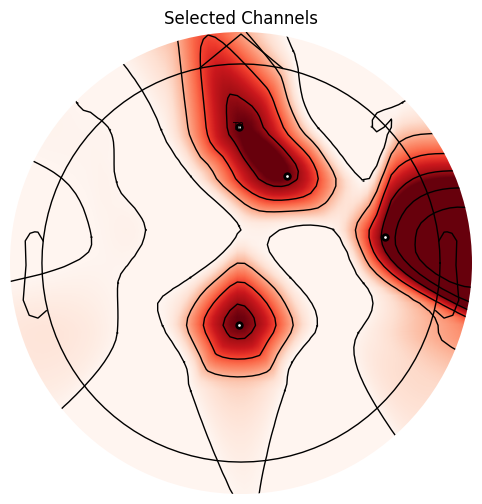

sponL vs sponT
Top channels (Accuracy>0.5, Max: 4 channels): [1, 11]


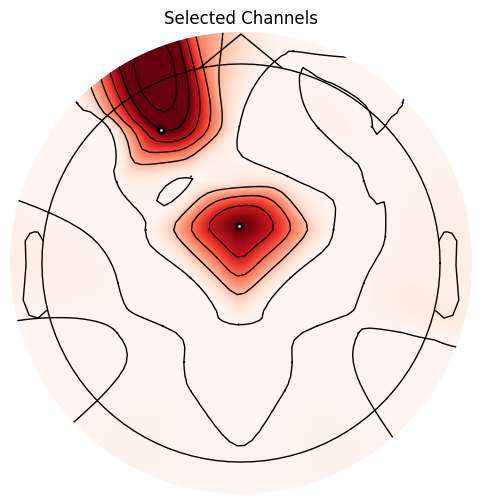

sponL vs instL
Top channels (Accuracy>0.5, Max: 4 channels): [1, 6, 7, 8, 18]


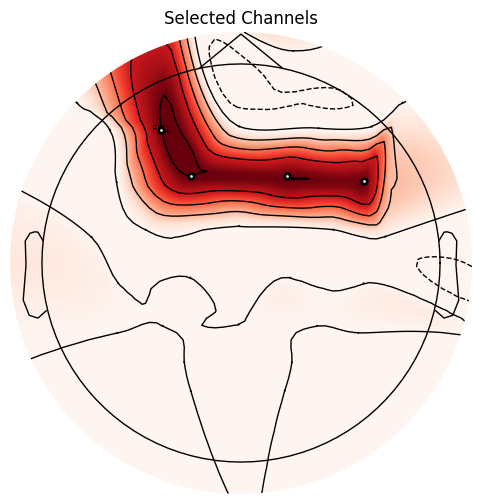

instT vs sponT
Top channels (Accuracy>0.5, Max: 4 channels): [1, 3, 4, 6, 8]


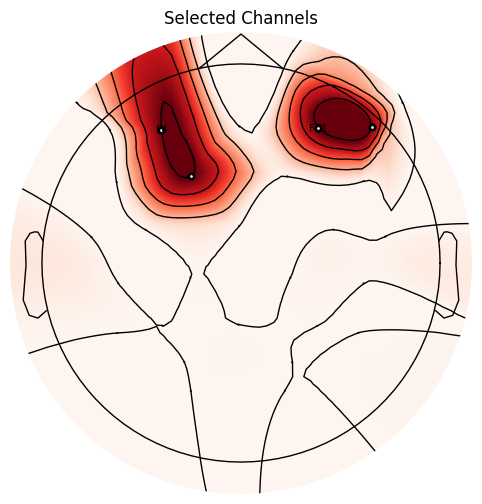

instT vs instL
Top channels (Accuracy>0.5, Max: 4 channels): [2, 3, 5, 7, 8]


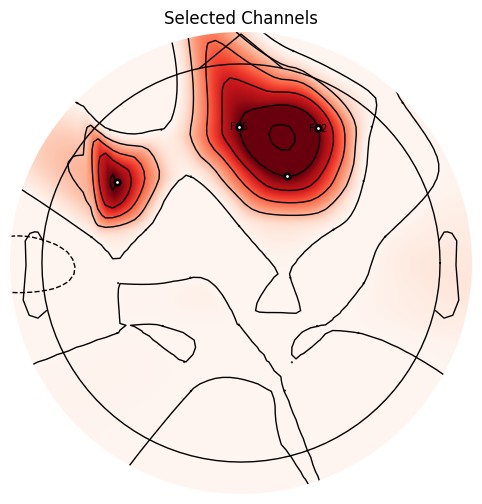

sponT vs instL
Top channels (Accuracy>0.5, Max: 4 channels): [1, 2, 3, 4, 6]


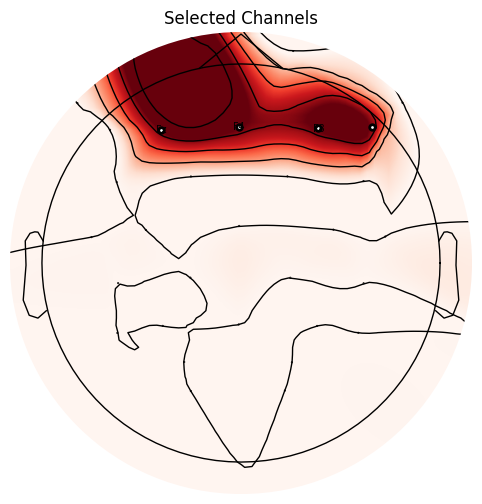

In [102]:
for c in class_list:
    print(c)
    d=filter_results(results_4class, c, 0.5)
    top_4=d['Channel'].tolist()[:5]
    print(f'Top channels (Accuracy>0.5, Max: 4 channels): {top_4}')
    plot_selected_channels_on_brain(d['Channel'].tolist()[:4], clist )